# Test Data Details
The test data contains North Conservatory sensor readings from 2019 pre-processed in the same way as in the training data case.

More specifically the test-data has the following properties:

1. Spans the first 6 months of 2019 (January 1, 2019 - June 30, 2019).

2. Only weekdays have been retained.

3. Re-scaled using the scaling values from the 2018 training data 
  * (standardScaler_2018.numpy -> continuous valued sensor data )
  * (minMaxScaler_2018.numpy -> categorical valued data )
  * feel free to load these with joblib.load
  

4. Each row of the dataset represents 24 hours of data extracted using overlapped sliding windows.

5. The rows/days have been shuffled, and are non-sequential.

6. 200 anomalies have been injected into different days.

7. Injected anomalies have only been added into the portions of the data that comes from continuously valued internal sensors (i.e., co2, temperature, dewpoint, and/or relative humidity). This means that the anomalies you are looking for will only take place between the 0 and 1536 reading on any given day.



# Load Test Data

In [1]:
%cd /home/irina/Hackathon/environmental-hackathon/
!pwd

/home/irina/Hackathon/environmental-hackathon
/home/irina/Hackathon/environmental-hackathon


In [2]:
import numpy as np 
import pandas as pd
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

#from nnViz_pytorch import 
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline
!pwd
N = 96 

/home/irina/Hackathon/environmental-hackathon


In [3]:
#device = torch.device("cuda:0")
device = torch.device('cpu')

#model.load_state_dict(torch.load("model_co2.v1.pth" , map_location=device)) #; model_co2.eval()
model1 = torch.load('model_co2.v1.pth', map_location=device)
model1.eval()
model1

Sequential(
  (0): Linear(in_features=96, out_features=48, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=48, out_features=24, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=24, out_features=12, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=12, out_features=24, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=24, out_features=48, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=48, out_features=96, bias=True)
)

In [4]:
test_red = np.load("data/test_data_reduced.npy")
s = test_red[10, :N]
v = torch.from_numpy(s).to(device)
v.shape

torch.Size([96])

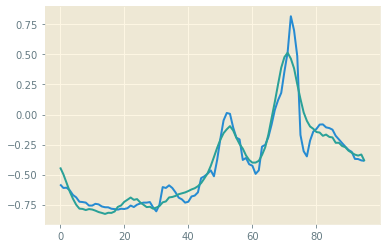

In [5]:
net  = model1.float() 
p = net.forward(v.float())
#     plt.plot(sample.numpy())
#     plt.plot(reconstruction.data.cpu().numpy())
# #reconstruction = model.forward(sample.to(targetDevice))}
plt.plot(v.numpy())
plt.plot(p.data.cpu().numpy())

In [6]:
import joblib
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
!pwd

/home/irina/Hackathon/environmental-hackathon


In [7]:
plt.style.use(['Solarize_Light2'])
test_data = joblib.load('test_data/test_dataset_2019.numpy')
test_data.shape

(9898, 2112)

In [8]:
2112/96

22.0

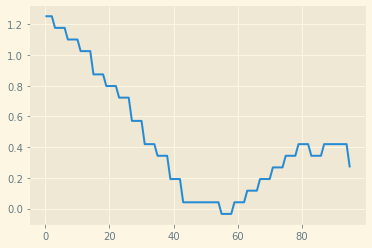

In [9]:
for i in range(16,17):
    plt.plot( test_data[0,96*i:96*(i+1)])

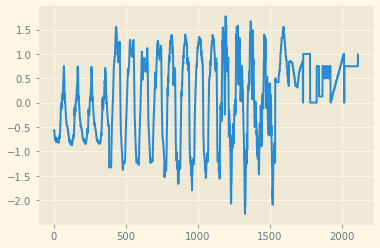

In [10]:
plt.plot( test_data[900,:] )

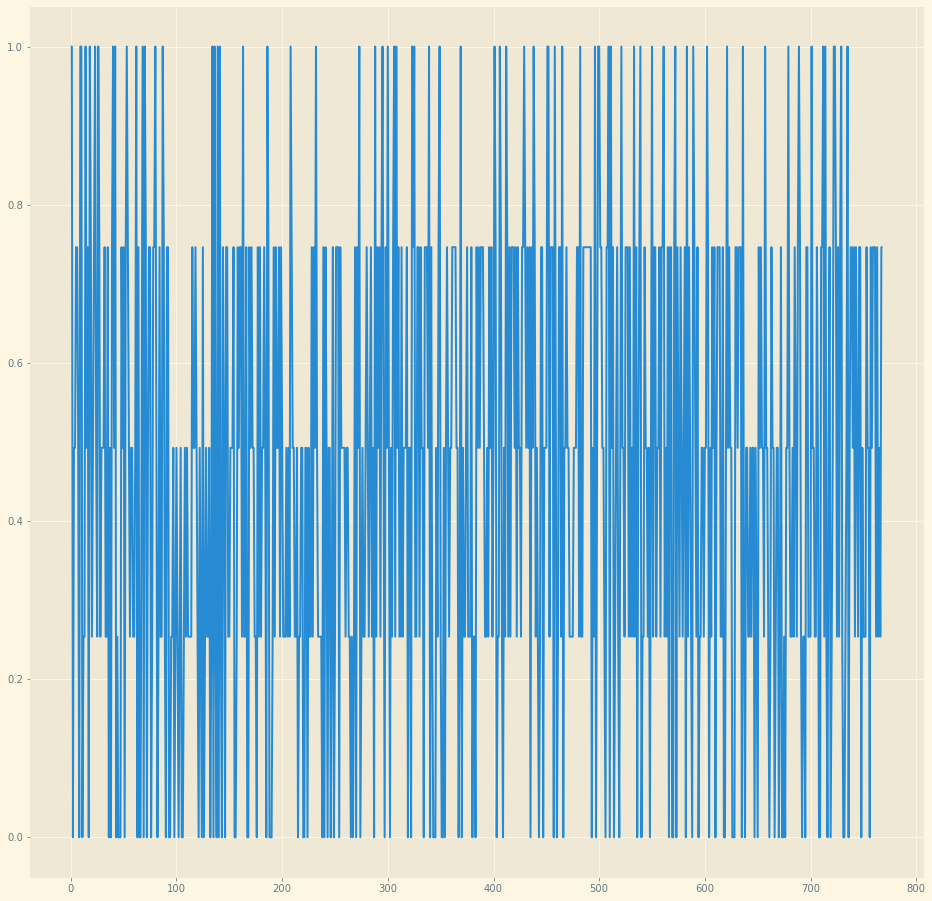

In [11]:
#plt.plot( test_data[5001,
fig = plt.figure(figsize=(16,16))
plt.plot(test_data[:384*2+1,2050])

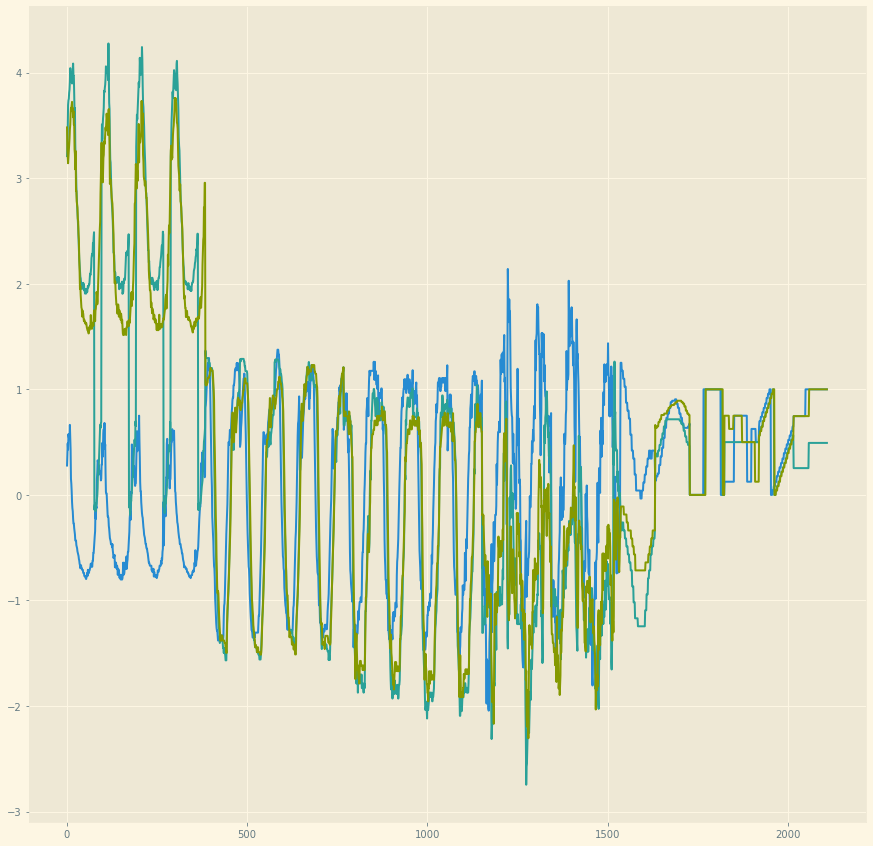

In [12]:
samplesInADay = 96 # 96 samples 15 minutes apart = 24 hours 
nSlidingWindowsToPlot = 3
#plt.figure()
fig = plt.figure(figsize=(15,15))
for iDay in range(nSlidingWindowsToPlot):
    startIndex = (iDay) * samplesInADay
    plt.plot(test_data[startIndex,:])

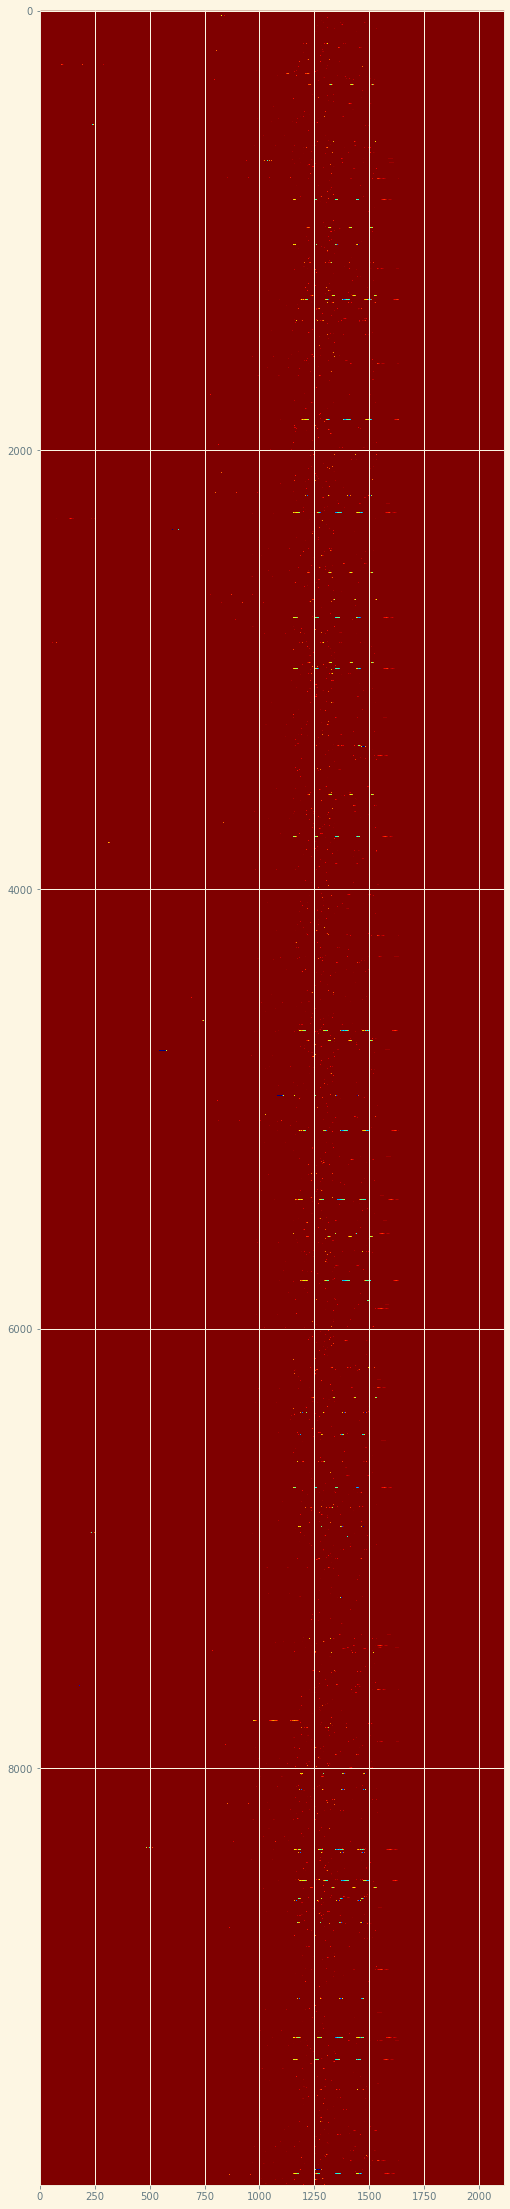

In [13]:
fig = plt.figure(figsize=(20,40))

plt.imshow(test_data[:,:], cmap='jet', vmin=-5, vmax=-2, interpolation='nearest')

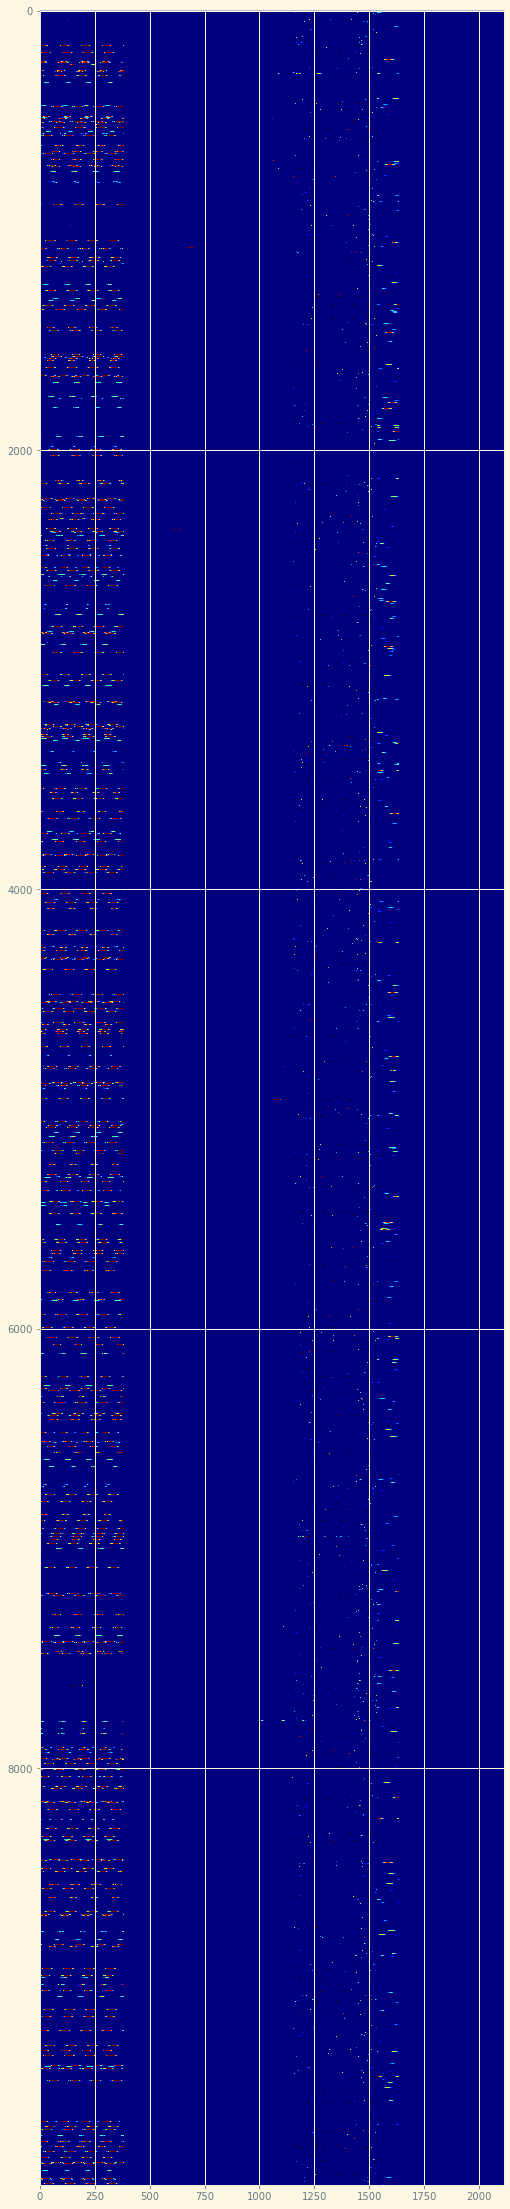

In [14]:
fig = plt.figure(figsize=(20,40))
plt.imshow(test_data[:,:], cmap='jet', vmin=2, vmax=3, interpolation='nearest')

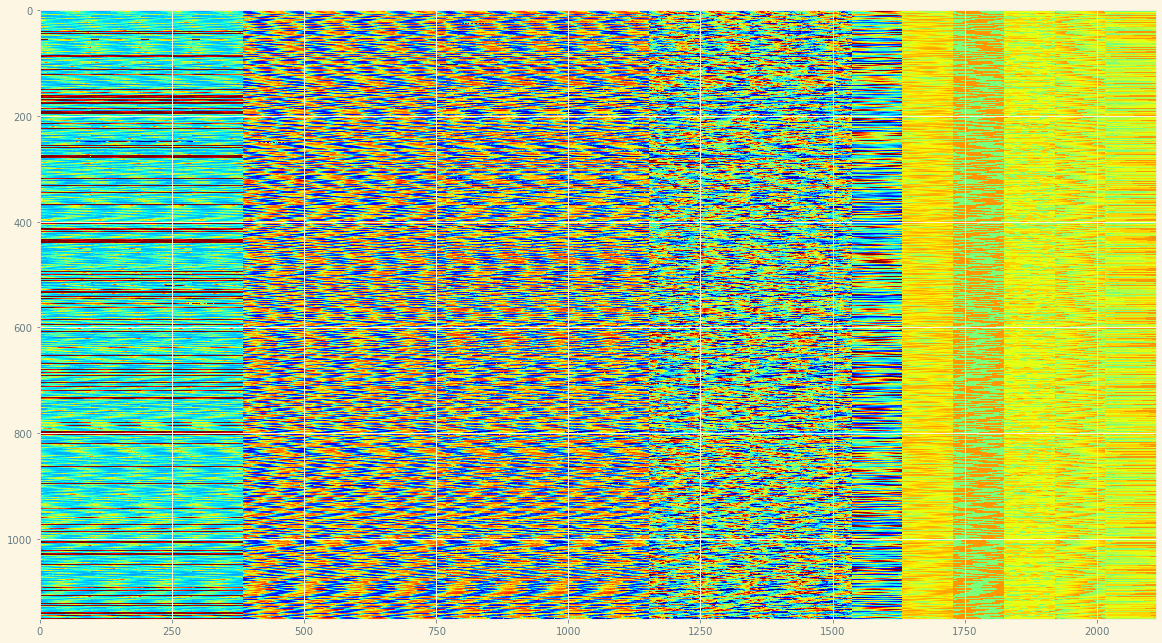

In [15]:
fig = plt.figure(figsize=(20,40))
plt.imshow(test_data[:96*12,:], cmap='jet', vmin=-2, vmax=2, interpolation='nearest')

In [16]:
def sumup(a):
    n_ts = 96
    n_ch = 4
    n_ty = 4
    b = np.zeros((a.shape[0], a.shape[1]- n_ty*(n_ch-1)*n_ts))
    for i in range(n_ty):
        for j in range(n_ts):
            c = np.column_stack((a[:, j+k*n_ts] for k in range(n_ch*i,n_ch*(i+1))))
            #print(c.shape)
            b[:,i*n_ts + j] = np.median(c, axis=1) 
            
            
    b[:,-6*n_ts:] = a[:,-6*n_ts:]
    return b

## Display folded data 

/home/irina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


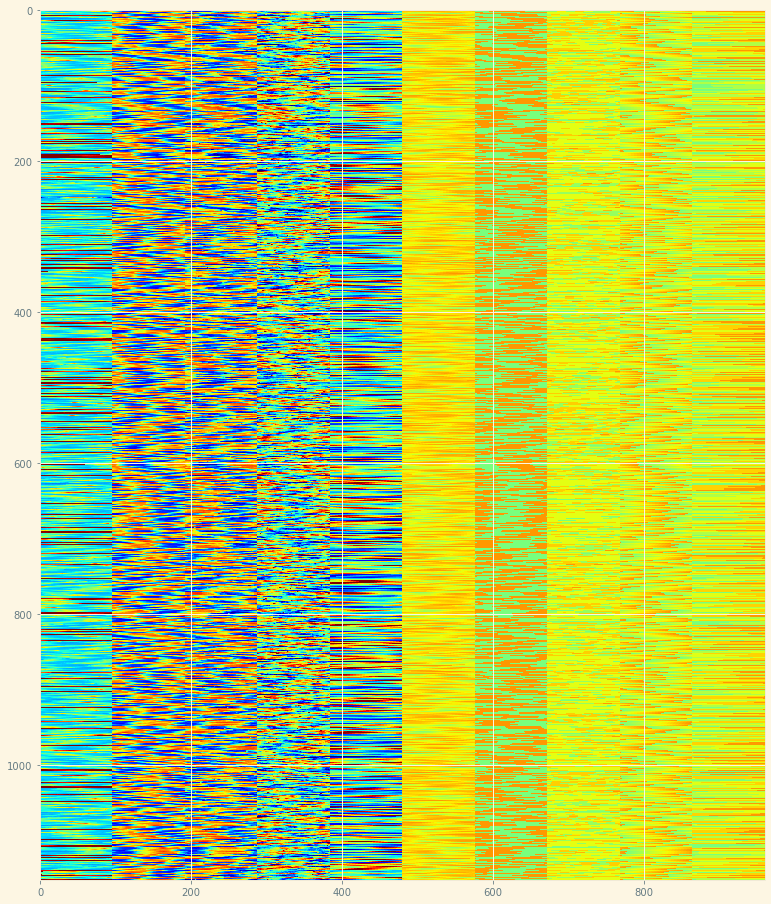

In [17]:
b = sumup(test_data)
fig = plt.figure(figsize=(16,16))
plt.imshow(b[:96*12,:], cmap='jet', vmin=-2, vmax=2, interpolation='nearest')

In [19]:
#!pwd
#np.save("../data/test_data_reduced.npy", b)

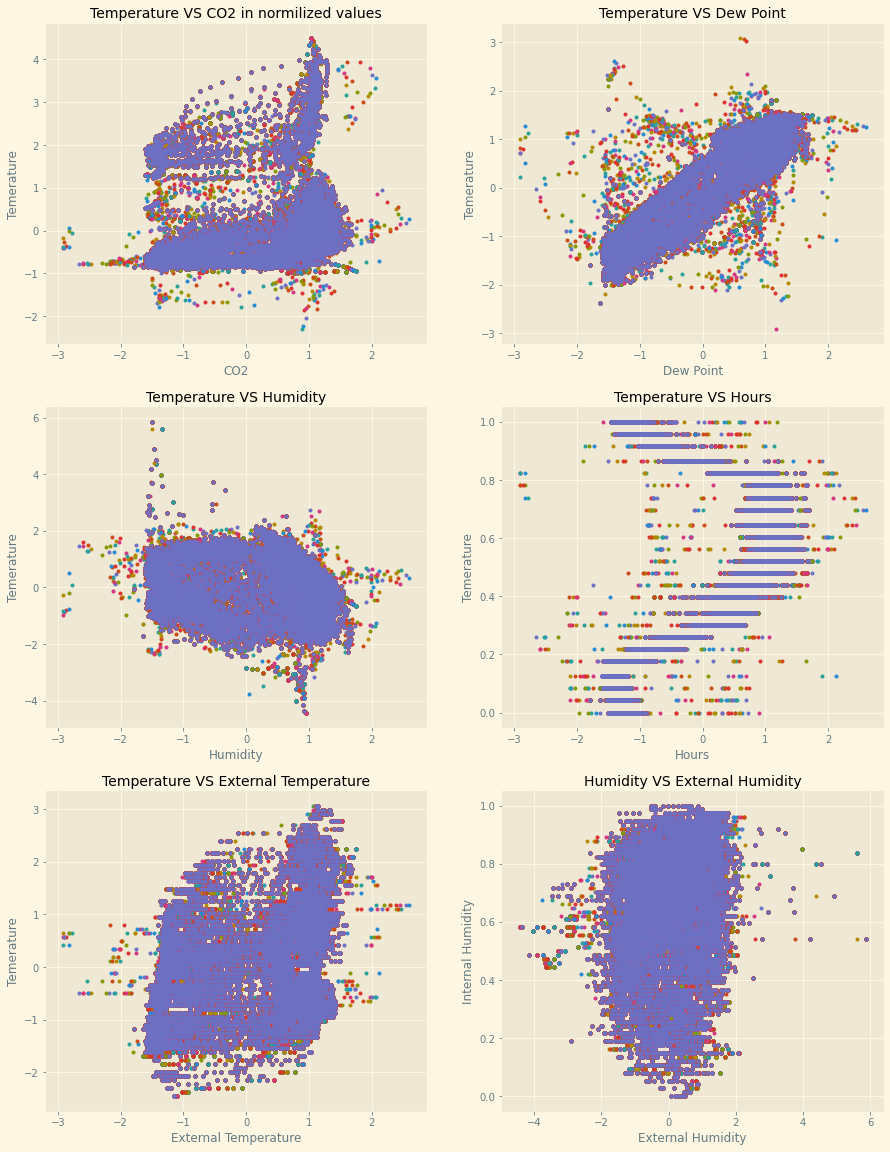

In [40]:
fs = 14
fig, axs = plt.subplots(3,2,figsize=(15,20))#, constrained_layout=True)
axs[0,0].plot(b[:,1*96:2*96], b[:,0*96:1*96], '.')
axs[0,0].set_title('Temperature VS CO2 in normilized values', fontsize=fs)
axs[0,0].set_xlabel('CO2')
axs[0,0].set_ylabel('Temerature')

axs[1,0].plot(b[:,1*96:2*96], b[:,3*96:4*96], '.')
axs[1,0].set_title('Temperature VS Humidity',  fontsize=fs)
axs[1,0].set_xlabel('Humidity')
axs[1,0].set_ylabel('Temerature')

axs[0,1].plot(b[:,1*96:2*96], b[:,2*96:3*96], '.')
axs[0,1].set_title('Temperature VS Dew Point',  fontsize=fs)
axs[0,1].set_xlabel('Dew Point')
axs[0,1].set_ylabel('Temerature')

axs[1,1].plot(b[:,1*96:2*96], b[:,8*96:9*96], '.')
axs[1,1].set_title('Temperature VS Hours',  fontsize=fs)
axs[1,1].set_xlabel('Hours')
axs[1,1].set_ylabel('Temerature')

axs[2,0].plot(b[:,1*96:2*96], b[:,4*96:5 *96], '.')
axs[2,0].set_title('Temperature VS External Temperature',  fontsize=fs)
axs[2,0].set_xlabel('External Temperature')
axs[2,0].set_ylabel('Temerature')

axs[2,1].plot(b[:,3*96:4*96], b[:,5*96:6*96], '.')
axs[2,1].set_title('Humidity VS External Humidity',  fontsize=fs)
axs[2,1].set_xlabel('External Humidity')
axs[2,1].set_ylabel('Internal Humidity')

plt.show()

# Your Goal

Your objective is to submit a text file that locates the 200 injected anomalies in this dataset. If your submission file contains more than 200 lines, we'll ignore beyond the first 200.

Each line of the text file should contain a unique day (i.e., test_data row index) in which an anomaly was detected.

You can also optionally add an additional indicator for the start sample within the day where the anomaly begins. Note that it is also possible to submit anomaly start samples for only a subset of days. Below we provide some examples as well as parser code so that you can be sure that your submission will be undersood by our grading process.


# Grading

Each correct detection of an anomalous day will earn 1 point, and correct anomaly start sample detections (within a 50 index margin) will earn half a point. There are no point deductions for incorrect answers, and partially credit is possible for correct day detections with incorrect start samples.

The max total score is `200*1 + 200*.5 = 300` points.

Since this is a very challenging problem, we'll do our best to grade on a curve relative to the most successful submission.

# Submission Samples


An example submission with both *day and start sample indicators* might look like the following:

-----
**-- team_01_submission.txt --**


`10, 1023   
56, 425
..
`

The first line of this submissino states that an anomaly was detected on the 10th day/row in the test_data, starting at the 1023 sample.

-----

Similarly, an example submission with *only day indicators* might look like:

**-- team_01_submission.txt --**

`
10, 
56, 
..
`

-----

Lastly, an example submission with *day indicators and some start sample indicators* might look like:

**-- team_01_submission.txt --**

`
10, 
56, 425
..
`





# Submission Parser

In [31]:
%%writefile sample_submission.txt
10,
54, 425
100, 100

Writing sample_submission.txt


In [32]:
def parse_submission ( filename ):
    dayIndicators = [] 
    startSampleIndicators = []
    lineCount = 0 
    with open(filename) as submission_text:
        line = submission_text.readline()        
        while line:
            if lineCount > 200: break
                    
            dayIndicators += [line.split(',')[0].strip()]
            startSampleIndicators += [line.split(',')[1].strip()]
            
            print( f'parsing line#{lineCount}: {line}' )
            line = submission_text.readline()
            lineCount += 1
            
    return dayIndicators, startSampleIndicators

In [33]:
parse_submission ( 'sample_submission.txt')

parsing line#0: 10,

parsing line#1: 54, 425

parsing line#2: 100, 100



(['10', '54', '100'], ['', '425', '100'])